In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [4]:
train_df = pd.read_pickle('train_df')
test_df = pd.read_pickle('test_df')
cv_df = pd.read_pickle('cv_df')
from scipy import sparse

train_gene_feature_onehotCoding = sparse.load_npz("train_gene_feature_onehotCoding.npz")
train_variation_feature_onehotCoding = sparse.load_npz("train_variation_feature_onehotCoding.npz")
test_gene_feature_onehotCoding = sparse.load_npz("test_gene_feature_onehotCoding.npz")
test_variation_feature_onehotCoding = sparse.load_npz("test_variation_feature_onehotCoding.npz")
cv_gene_feature_onehotCoding = sparse.load_npz("cv_gene_feature_onehotCoding.npz")
cv_variation_feature_onehotCoding = sparse.load_npz("cv_variation_feature_onehotCoding.npz")

In [5]:
train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')
y_cv=np.load('y_cv.npy')


In [47]:
y_train

array([4, 1, 6, ..., 3, 5, 6], dtype=int64)

In [15]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


## Analysis on Gene Feature

## Gene Frequency corresponding to each class

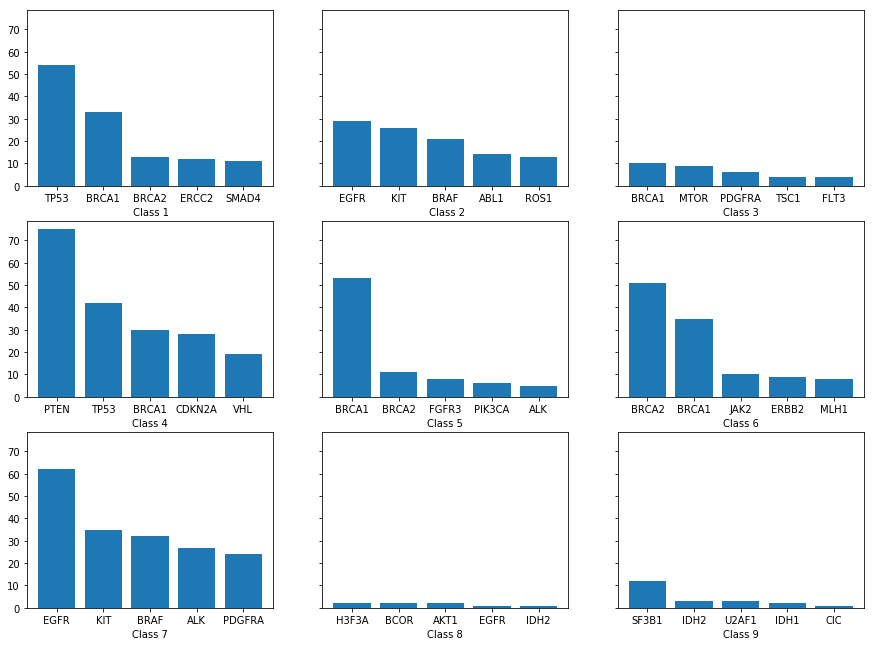

In [139]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(15,11))
i=1
p=[' Class 1',' Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
for row in axes:
    for col in row:
        c={}
        c=train_df[train_df['Class']==i]['Gene'].value_counts()[0:5]
        
        a=c.to_dict()
        col.bar(list(a.keys()),list(a.values()))
        col.set_xlabel(p[i-1])
        i+=1

We can see that BRCA1 and BRCA2 has occurred many times in class 1,3,4,5,6.

### Frequency of most occuring Genes corresponding to each class

In [5]:
train_df['Gene'].value_counts()[0:5]

BRCA1    161
TP53     103
EGFR      98
PTEN      83
BRCA2     77
Name: Gene, dtype: int64

These are the most occuring genes

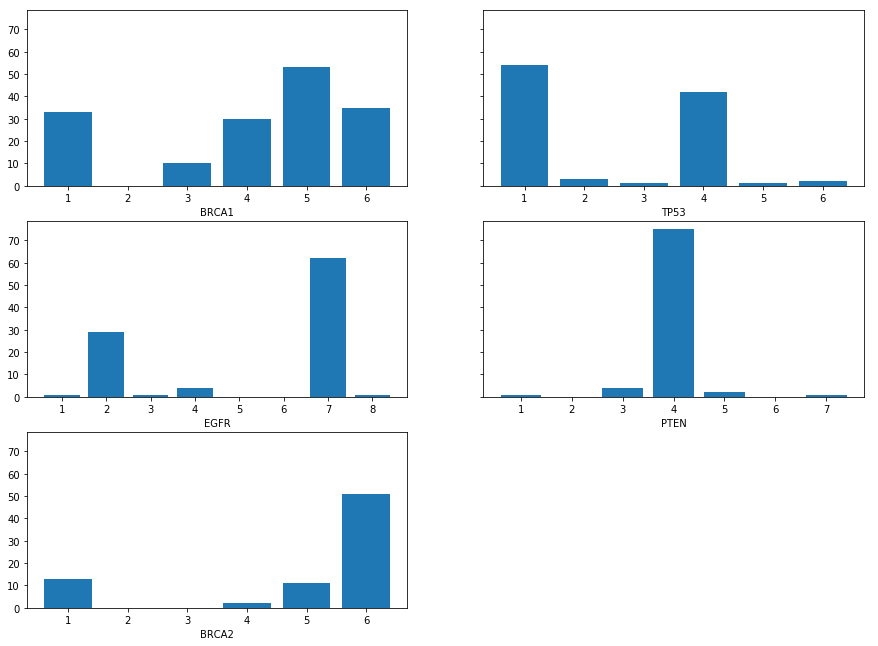

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(15,11))
i=0
p=[' Class 1',' Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']
gene=['BRCA1','TP53','EGFR','PTEN','BRCA2']
for row in axes:
    for col in row:
        c={}
        if i<5:
            c=train_df[train_df['Gene']==gene[i]]['Class'].value_counts()
            a=c.to_dict()
            col.bar(list(a.keys()),list(a.values()))
            col.set_xlabel(gene[i])
            i+=1
axes[-1, -1].axis('off')
plt.show()

1. We can see that BRCA1 which is most occuring gene does not occur even once in class 2/7/8/9.
<br>
2. Class 7 contains more number of EGFR gene.
<br>
3. Class 9 does not contain any of the most occuring genes.

### Analysis on Variation Feature

In [8]:
counts=train_df['Variation'].value_counts().reset_index()
counts.columns=['Occurence', 'Count']
count_dict={}
count_dict=counts.Count.value_counts()
total=sum(count_dict.values)
for a, b in count_dict.iteritems():
    print('{}% of variations has {} occurence'.format(np.round((b/total)*100,2 ),a))

98.65% of variations has 1 occurence
0.98% of variations has 2 occurence
0.1% of variations has 3 occurence
0.05% of variations has 60 occurence
0.05% of variations has 47 occurence
0.05% of variations has 45 occurence
0.05% of variations has 19 occurence
0.05% of variations has 4 occurence


We can infer that 98.6% of variations are unique.

### Analysis on Text Feature

In [113]:
train_df.head(5)

,ID,Gene,Variation,Class,TEXT,word_len,char_len
2426,2426,BRCA1,C64G,4,published analyses effects missense mutations ...,17926,130265
636,636,CDKN1A,Truncating Mutations,1,introduction loss control mammalian cell cycle...,7234,53047
703,703,ERBB2,E812K,6,purpose mutations associated resistance kinase...,4961,37512
1455,1455,FGFR2,K659N,7,activating mutations tyrosine kinase domain re...,8077,59908
103,103,MSH6,R976H,1,msh6 gene one mismatch repair genes involved h...,13352,100388


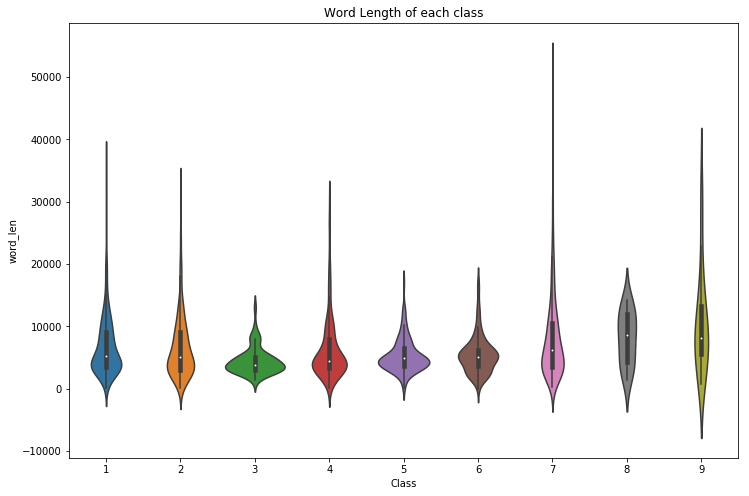

In [11]:
plt.figure(figsize=(12,8))
sns.violinplot(x="Class", y="word_len", data=train_df)
plt.title('Word Length of each class')
plt.show()

we can see that most classes have word length between 0 to 10000.

### Words with top TFIDF Values

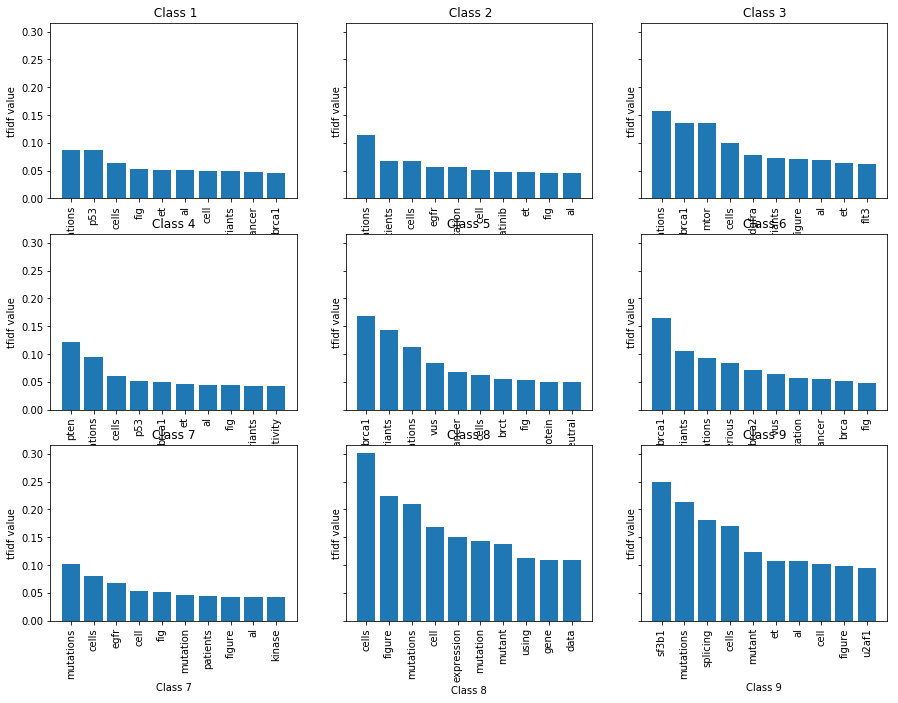

In [162]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(15,11))
count=1
classes=[' Class 1',' Class 2','Class 3','Class 4','Class 5','Class 6','Class 7','Class 8','Class 9']

for row in axes:
    for col in row:
        tf_idf_vect = TfidfVectorizer(min_df=10)
        vec1=tf_idf_vect.fit_transform(train_df[train_df['Class']==count]['TEXT'])

        features=pd.DataFrame(tf_idf_vect.get_feature_names())
        mean_tf=np.mean(vec1,axis=0)
        x=np.array(mean_tf)[0].tolist()
        idf_values=sorted(x, reverse=True)
        # taking top 20 features
        important_feat=[]
        important_feat=np.argsort((x))[::-1]
        important_feat=important_feat[:10]
        important_feat
        imp_feat=[]
        for index in important_feat:
            imp_feat.append(features.iloc[index])
        x=np.array(imp_feat)
        feature=[]
        for i in x:
            for j in i:
                feature.append(j)
        clas={}
        c=0
        common={}
        for i in feature:
            common[i]=idf_values[c]
            c+=1
        col.bar(list(common.keys()),list(common.values()))
        col.set_xticklabels(list(common.keys()),rotation=90)
        col.set_xlabel(classes[count-1])
        col.set_title(classes[count-1])
        col.set_ylabel('tfidf value')
        count+=1

## ML Models

In [4]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    #C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [5]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [6]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


In [7]:


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [8]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [9]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [10]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

5. Assignments


<ol>
    <li> Apply All the models with tf-idf features (Replace CountVectorizer with tfidfVectorizer and run the same cells)</li>
    <li> Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values</li>
    <li>Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams</li>
    <li> Try any of the feature engineering techniques discussed in the course to reduce the CV and test log-loss to a value less than 1.0</li>
</ol>

In [23]:
train_df.head()

,ID,Gene,Variation,Class,TEXT
2426,2426,BRCA1,C64G,4,published analyses effects missense mutations ...
636,636,CDKN1A,Truncating Mutations,1,introduction loss control mammalian cell cycle...
703,703,ERBB2,E812K,6,purpose mutations associated resistance kinase...
1455,1455,FGFR2,K659N,7,activating mutations tyrosine kinase domain re...
103,103,MSH6,R976H,1,msh6 gene one mismatch repair genes involved h...


In [24]:
train_variation_feature_onehotCoding

<2124x1964 sparse matrix of type '<class 'numpy.int64'>'
	with 2431 stored elements in Compressed Sparse Row format>

In [224]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer()
train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
test_text_feature = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])

In [13]:
print(train_variation_feature_onehotCoding.shape)
print(train_gene_feature_onehotCoding.shape)
train_text_feature.shape

(2124, 1964)
(2124, 229)


(2124, 126099)

In [225]:
train_text_feature = normalize(train_text_feature, axis=0)

# we use the same vectorizer that was trained on train data

# don't forget to normalize every feature
test_text_feature = normalize(test_text_feature, axis=0)

# we use the same vectorizer that was trained on train data

# don't forget to normalize every feature
cv_text_feature = normalize(cv_text_feature, axis=0)

In [29]:
train_vec = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train_text_feature))
test_vec = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test_text_feature))
cv_vec = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv_text_feature))

## Naive Bayes

for alpha = 1e-05
Log Loss : 1.2567927668300418
for alpha = 0.0001
Log Loss : 1.2629049300903104
for alpha = 0.001
Log Loss : 1.2686550032314035
for alpha = 0.1
Log Loss : 1.2770262355822313
for alpha = 1
Log Loss : 1.313619241850694
for alpha = 10
Log Loss : 1.3615423725765872
for alpha = 100
Log Loss : 1.2457778208833945
for alpha = 1000
Log Loss : 1.188761554861517


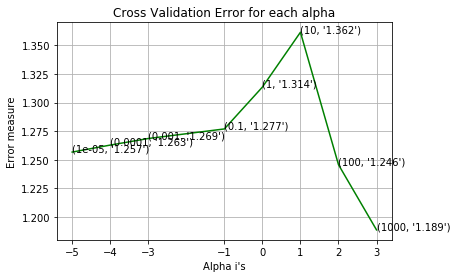

For values of best alpha =  1000 The train log loss is: 0.8376778669235427
For values of best alpha =  1000 The cross validation log loss is: 1.188761554861517
For values of best alpha =  1000 The test log loss is: 1.1764751736807895


In [52]:


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)


predict_y = sig_clf.predict_proba(train_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Testing the model with best hyper paramters

Log Loss : 1.188761554861517
Number of missclassified point : 0.39473684210526316
-------------------- Confusion matrix --------------------


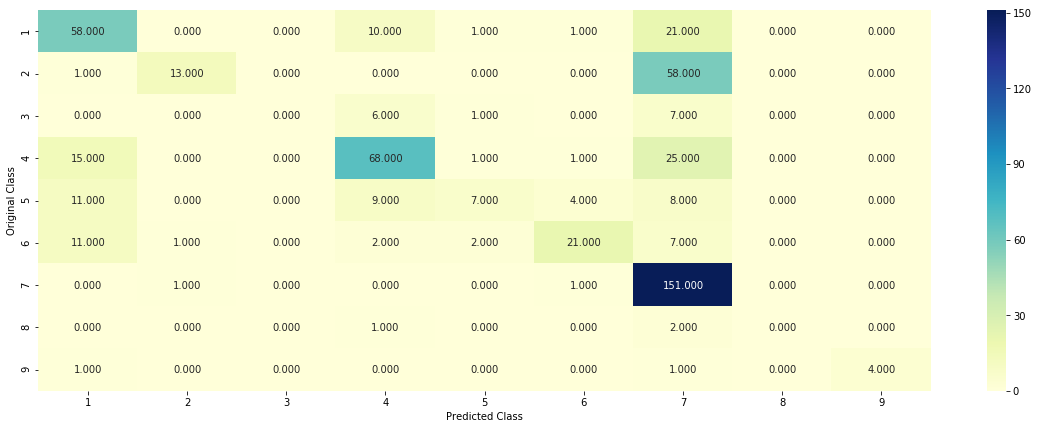

-------------------- Precision matrix (Columm Sum=1) --------------------


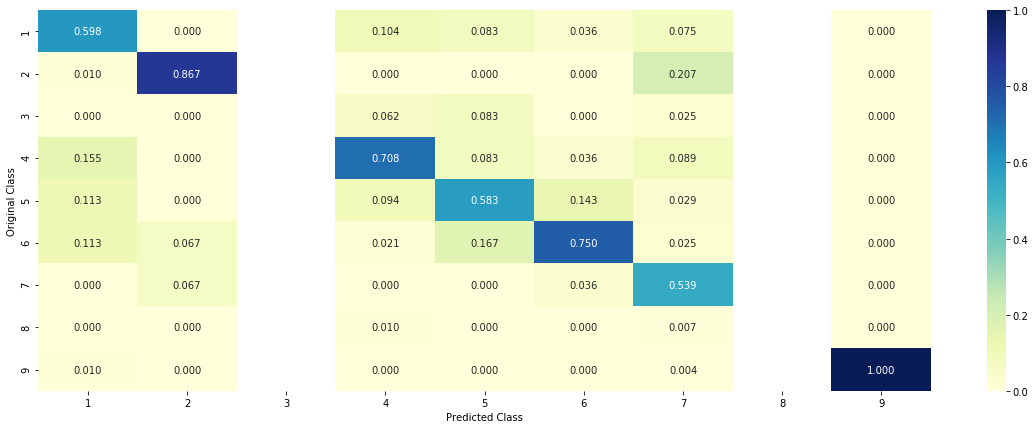

-------------------- Recall matrix (Row sum=1) --------------------


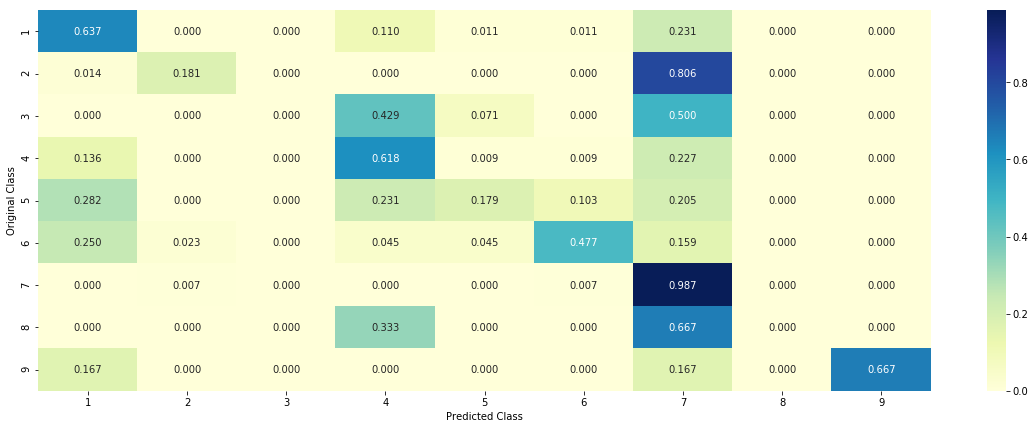

In [55]:

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_vec)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_vec)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_vec.toarray()))

### Feature Importance, Correctly classified point

In [11]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
# feature importance for tfidf features
def get_impfeature_names_tf(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = TfidfVectorizer()
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [35]:
test_vec=test_vec.tocsr()

In [57]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
test_vec=test_vec.tocsr()
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0161 0.0605 0.0191 0.0315 0.033  0.0213 0.8125 0.0038 0.0021]]
Actual Class : 7
--------------------------------------------------
15 Text feature [cells] present in test data point [True]
16 Text feature [kinase] present in test data point [True]
20 Text feature [cell] present in test data point [True]
21 Text feature [presence] present in test data point [True]
22 Text feature [activated] present in test data point [True]
23 Text feature [contrast] present in test data point [True]
24 Text feature [activation] present in test data point [True]
25 Text feature [phosphorylation] present in test data point [True]
26 Text feature [inhibitor] present in test data point [True]
28 Text feature [also] present in test data point [True]
29 Text feature [shown] present in test data point [True]
30 Text feature [expressing] present in test data point [True]
31 Text feature [10] present in test data point [True]
32 Text feature [signaling] pr

### Feature Importance, Incorrectly classified point

In [68]:
test_point_index = 350
no_feature = 100
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5857 0.0275 0.0171 0.2585 0.0318 0.024  0.0492 0.0036 0.0026]]
Actual Class : 4
--------------------------------------------------
13 Text feature [protein] present in test data point [True]
14 Text feature [type] present in test data point [True]
15 Text feature [wild] present in test data point [True]
16 Text feature [one] present in test data point [True]
19 Text feature [dna] present in test data point [True]
20 Text feature [containing] present in test data point [True]
21 Text feature [two] present in test data point [True]
23 Text feature [region] present in test data point [True]
24 Text feature [either] present in test data point [True]
25 Text feature [binding] present in test data point [True]
26 Text feature [function] present in test data point [True]
27 Text feature [results] present in test data point [True]
28 Text feature [expression] present in test data point [True]
29 Text feature [therefore] present in test dat

### K Nearest Neighbour Classification

for alpha = 5
Log Loss : 1.3265398215899902
for alpha = 11
Log Loss : 1.4042284081495355
for alpha = 15
Log Loss : 1.4409212647173233
for alpha = 21
Log Loss : 1.467403544557008
for alpha = 31
Log Loss : 1.5138769837737722
for alpha = 41
Log Loss : 1.5456574333802615
for alpha = 51
Log Loss : 1.5343982678526018
for alpha = 99
Log Loss : 1.4213936169591672


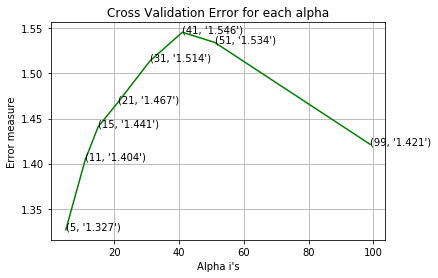

For values of best alpha =  5 The train log loss is: 1.020680894820197
For values of best alpha =  5 The cross validation log loss is: 1.3290953937242058
For values of best alpha =  5 The test log loss is: 1.3265398215899902


In [69]:


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

predict_y = sig_clf.predict_proba(train_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))


#### Testing the model with best hyper paramters

Log loss : 1.3265398215899902
Number of mis-classified points : 0.4266917293233083
-------------------- Confusion matrix --------------------


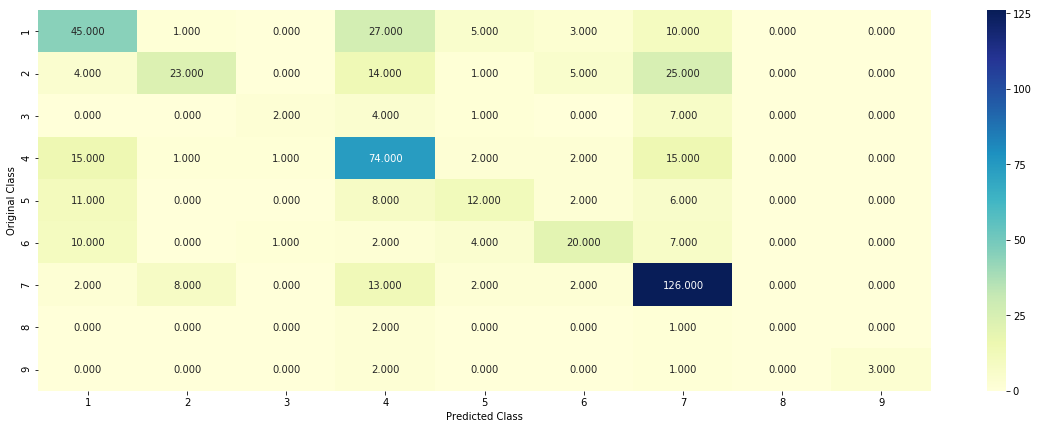

-------------------- Precision matrix (Columm Sum=1) --------------------


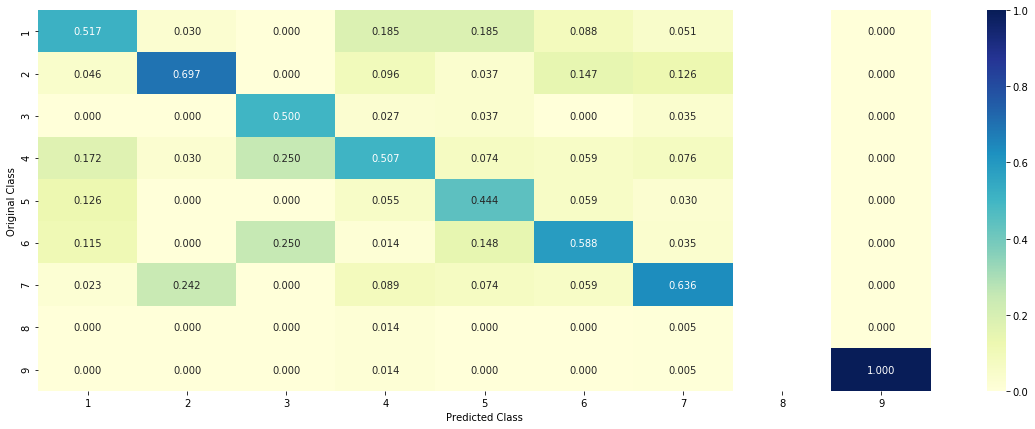

-------------------- Recall matrix (Row sum=1) --------------------


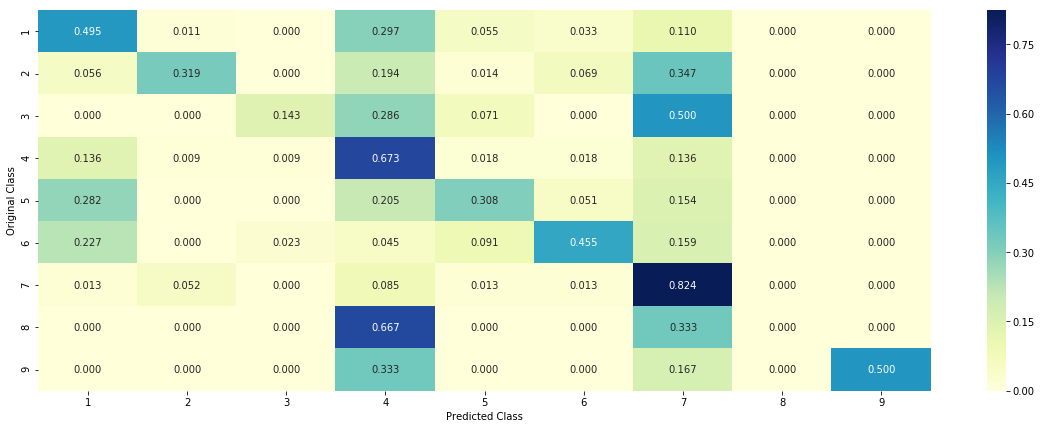

In [70]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_vec, train_y, cv_vec, cv_y, clf)

#### Feature Importance, Inorrectly classified point

In [77]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

test_point_index = 1

predicted_cls = sig_clf.predict(test_vec[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_vec[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 7
The  5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


#### Feature Importance, Correctly classified point

In [74]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

test_point_index = 1

predicted_cls = sig_clf.predict(test_vec[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_vec[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points : Counter({7: 5})


### Logistic Regression with class balancing

for alpha = 1e-06
Log Loss : 1.3762267471928669
for alpha = 1e-05
Log Loss : 1.3858761287675025
for alpha = 0.0001
Log Loss : 1.3251788401733469
for alpha = 0.001
Log Loss : 1.0974391839339572
for alpha = 0.01
Log Loss : 1.098482224226122
for alpha = 0.1
Log Loss : 1.206796920687988
for alpha = 1
Log Loss : 1.4435460203183215
for alpha = 10
Log Loss : 1.486851536803223
for alpha = 100
Log Loss : 1.4914874092809136


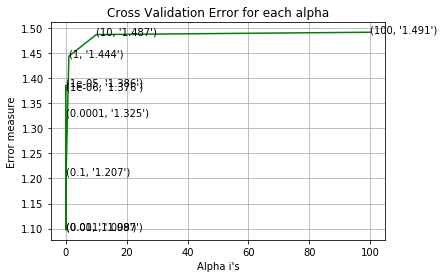

For values of best alpha =  0.001 The train log loss is: 0.5611355366800372
For values of best alpha =  0.001 The cross validation log loss is: 1.0974391839339572
For values of best alpha =  0.001 The test log loss is: 1.0649284801253855


In [78]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

predict_y = sig_clf.predict_proba(train_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing the model with best hyper paramters

Log loss : 1.0974391839339572
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


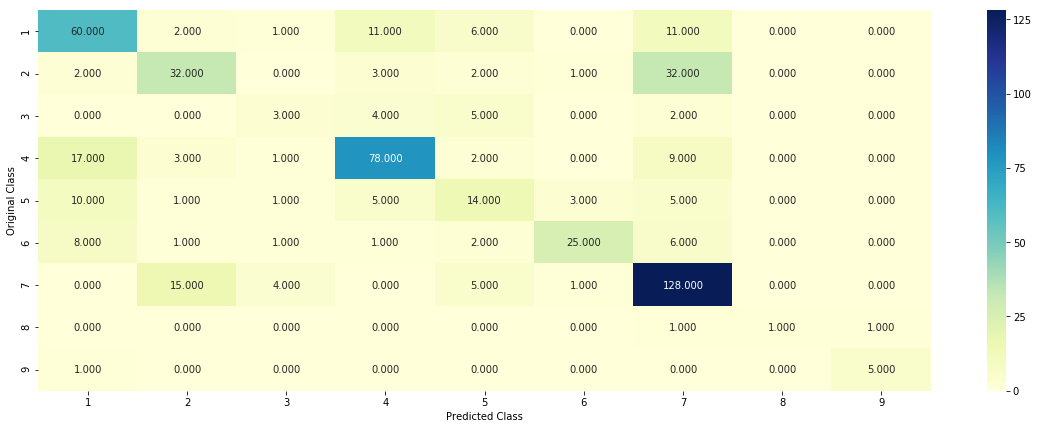

-------------------- Precision matrix (Columm Sum=1) --------------------


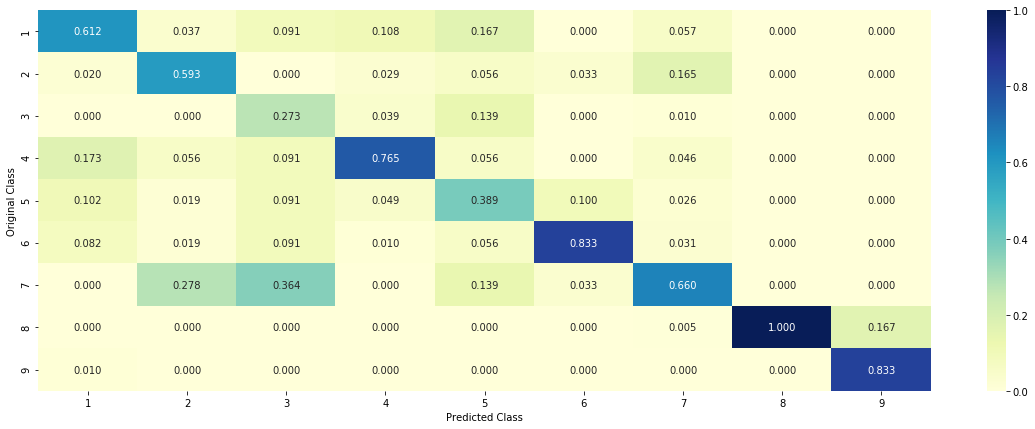

-------------------- Recall matrix (Row sum=1) --------------------


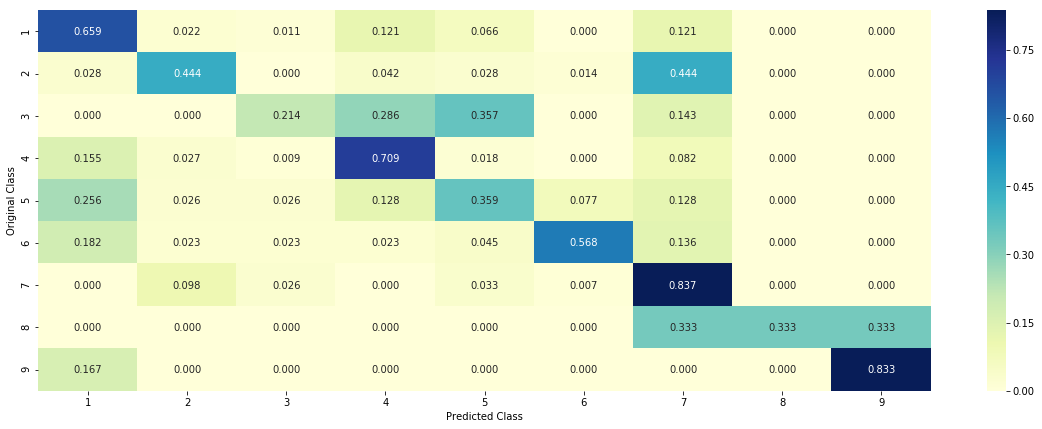

In [80]:
### clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_vec, train_y, cv_vec, cv_y, clf)

#### Feature Importance, Correctly classified point

In [81]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0241 0.0467 0.0147 0.0246 0.0221 0.0141 0.8443 0.0048 0.0047]]
Actual Class : 7
--------------------------------------------------
36 Text feature [constitutive] present in test data point [True]
65 Text feature [constitutively] present in test data point [True]
114 Text feature [activated] present in test data point [True]
158 Text feature [phosphotyrosine] present in test data point [True]
235 Text feature [activation] present in test data point [True]
371 Text feature [technology] present in test data point [True]
455 Text feature [interleukin] present in test data point [True]
488 Text feature [kinase] present in test data point [True]
Out of the top  500  features  8 are present in query point


#### Feature Importance, Incorrectly classified point

In [82]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1653 0.2326 0.0324 0.1208 0.1394 0.0842 0.2039 0.0101 0.0113]]
Actual Class : 6
--------------------------------------------------
116 Text feature [subgroup] present in test data point [True]
261 Text feature [median] present in test data point [True]
404 Text feature [formalin] present in test data point [True]
412 Text feature [therapy] present in test data point [True]
494 Text feature [ffpe] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Logistic Regression without class balancing

for alpha = 1e-06
Log Loss : 1.3587304074753803
for alpha = 1e-05
Log Loss : 1.3624834639880334
for alpha = 0.0001
Log Loss : 1.3225394674388362
for alpha = 0.001
Log Loss : 1.1135641054292025
for alpha = 0.01
Log Loss : 1.1294188383338022
for alpha = 0.1
Log Loss : 1.1662444045999807
for alpha = 1
Log Loss : 1.438973960607487


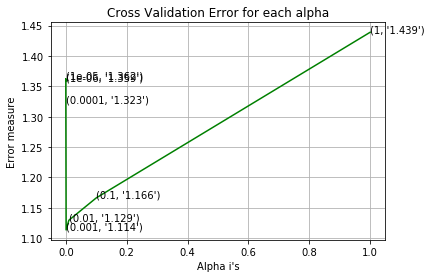

For values of best alpha =  0.001 The train log loss is: 0.5565790044926407
For values of best alpha =  0.001 The cross validation log loss is: 1.1135641054292025
For values of best alpha =  0.001 The test log loss is: 1.0729974789587016


In [83]:

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

predict_y = sig_clf.predict_proba(train_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

#### Testing the model with best hyper paramters

Log loss : 1.1135641054292025
Number of mis-classified points : 0.34398496240601506
-------------------- Confusion matrix --------------------


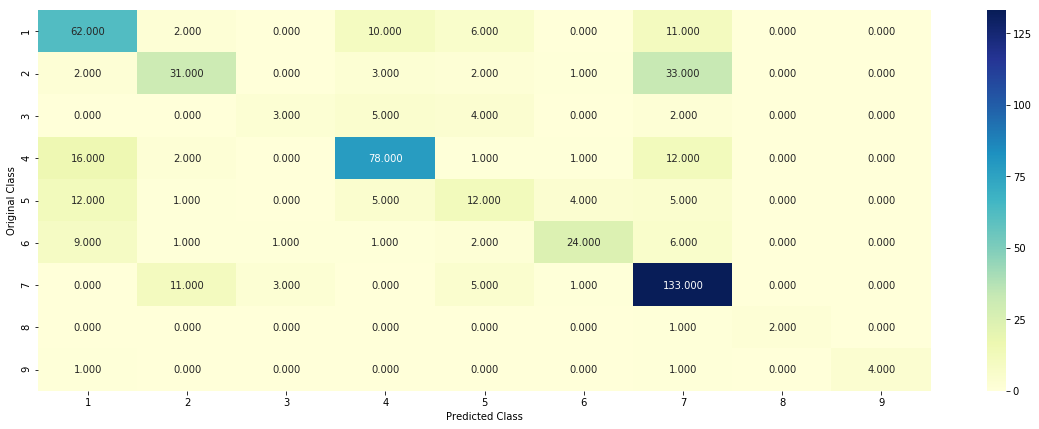

-------------------- Precision matrix (Columm Sum=1) --------------------


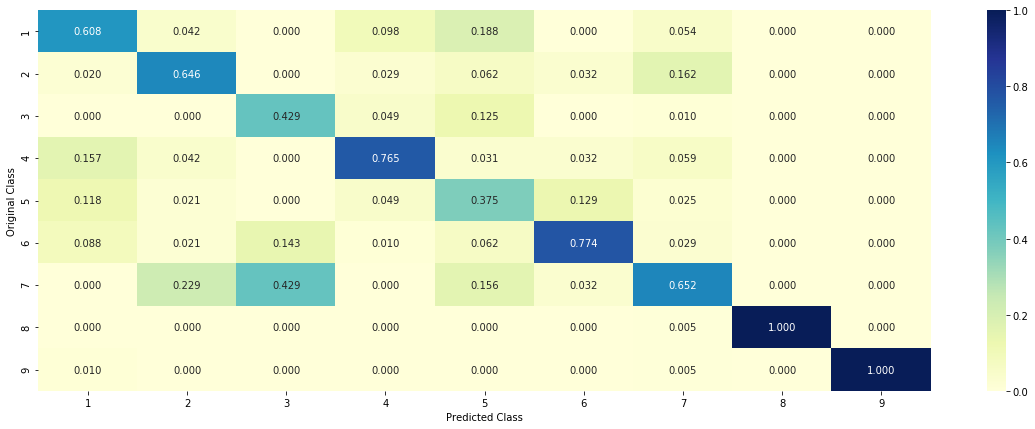

-------------------- Recall matrix (Row sum=1) --------------------


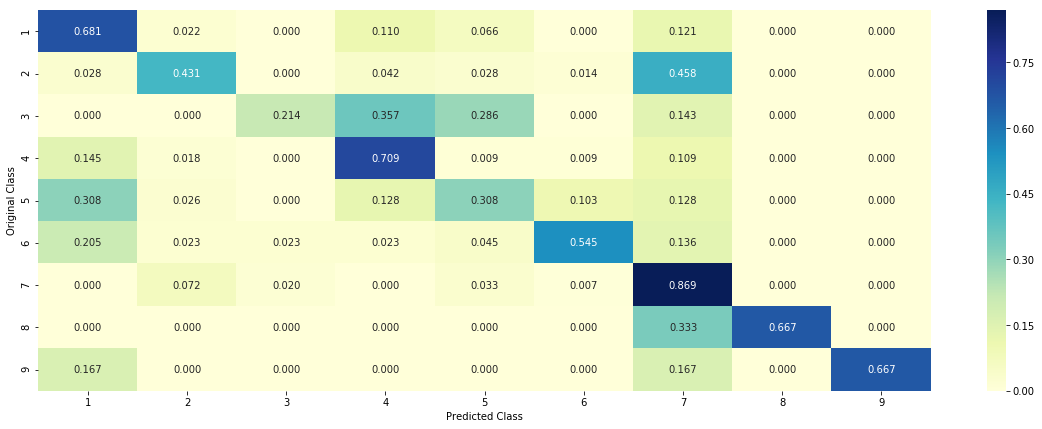

In [87]:


clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_vec, train_y, cv_vec, cv_y, clf)


#### Feature Importance, Correctly classified point

In [85]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0292 0.0523 0.01   0.0309 0.0189 0.0136 0.8383 0.0046 0.0022]]
Actual Class : 7
--------------------------------------------------
70 Text feature [constitutively] present in test data point [True]
101 Text feature [constitutive] present in test data point [True]
130 Text feature [activated] present in test data point [True]
200 Text feature [activation] present in test data point [True]
278 Text feature [phosphotyrosine] present in test data point [True]
299 Text feature [inhibited] present in test data point [True]
320 Text feature [technology] present in test data point [True]
376 Text feature [tyrosyl] present in test data point [True]
393 Text feature [kinase] present in test data point [True]
395 Text feature [phosphorylation] present in test data point [True]
413 Text feature [independence] present in test data point [True]
414 Text feature [ligand] present in test data point [True]
421 Text feature [py] present in test data

#### Feature Importance, Incorrectly classified point

In [86]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.1703 0.2399 0.0204 0.1178 0.1314 0.0821 0.223  0.0096 0.0055]]
Actual Class : 6
--------------------------------------------------
106 Text feature [subgroup] present in test data point [True]
268 Text feature [median] present in test data point [True]
326 Text feature [ffpe] present in test data point [True]
388 Text feature [therapy] present in test data point [True]
391 Text feature [formalin] present in test data point [True]
Out of the top  500  features  5 are present in query point


### Random Forest Classifier

In [88]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_vec, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_vec, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_vec)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

predict_y = sig_clf.predict_proba(train_vec)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2417309452150282
for n_estimators = 100 and max depth =  10
Log Loss : 1.1912829351753556
for n_estimators = 200 and max depth =  5
Log Loss : 1.228500684679421
for n_estimators = 200 and max depth =  10
Log Loss : 1.1812957438294787
for n_estimators = 500 and max depth =  5
Log Loss : 1.2236113739683498
for n_estimators = 500 and max depth =  10
Log Loss : 1.1763219005393661
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2277077844020792
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1740521033604074
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2279677047180988
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1721777847644939
For values of best estimator =  2000 The train log loss is: 0.6786572369508065
For values of best estimator =  2000 The cross validation log loss is: 1.1721777847644936
For values of best estimator =  2000 The test log loss is: 1.1609443840222373


#### Testing the model with best hyper paramters

Log loss : 1.1721777847644936
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


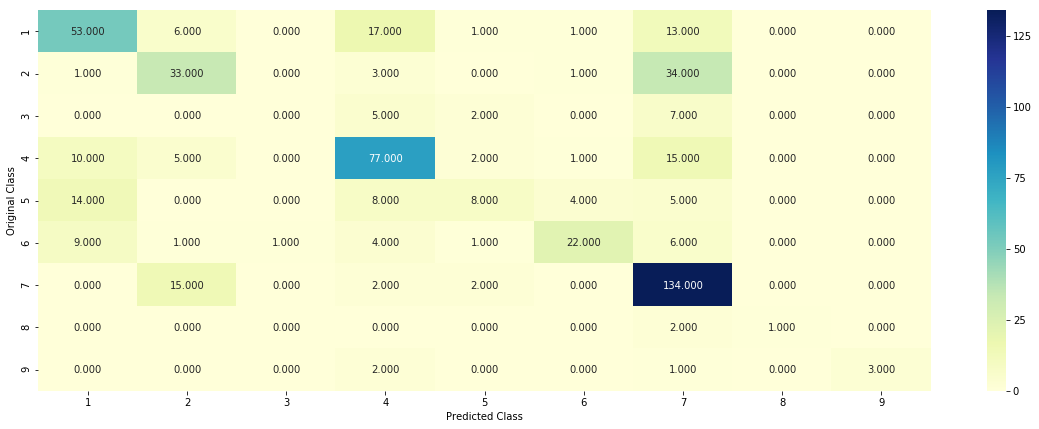

-------------------- Precision matrix (Columm Sum=1) --------------------


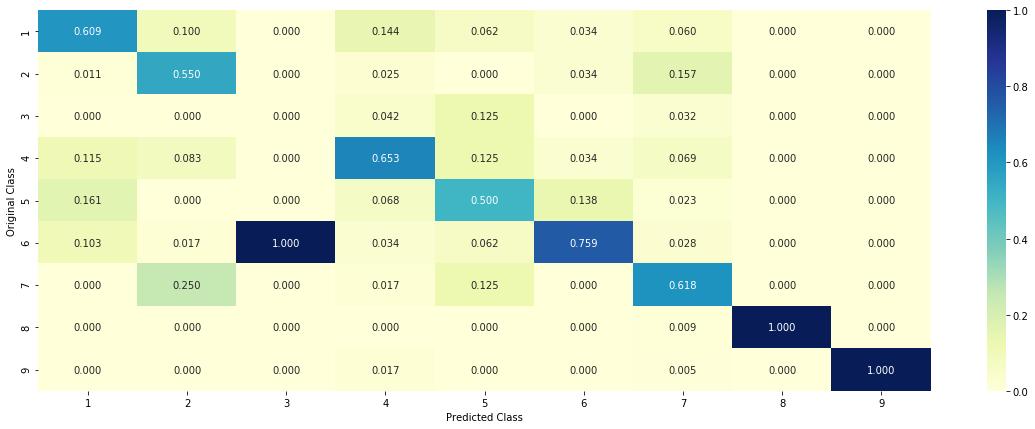

-------------------- Recall matrix (Row sum=1) --------------------


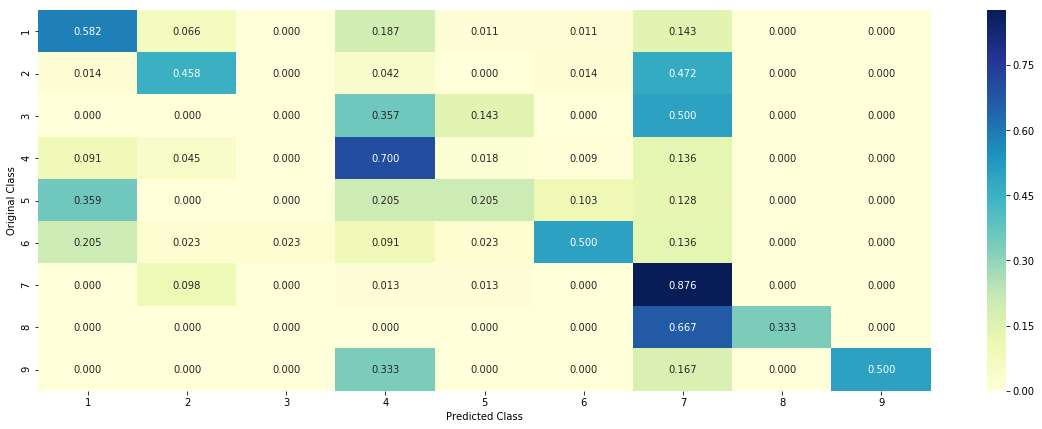

In [89]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_vec, train_y,cv_vec,cv_y, clf)

#### Feature Importance, Correctly classified point

In [90]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names_tf(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0294 0.1412 0.0157 0.0274 0.0374 0.0274 0.7136 0.0045 0.0034]]
Actual Class : 7
--------------------------------------------------
0 Text feature [activating] present in test data point [True]
1 Text feature [kinase] present in test data point [True]
2 Text feature [activation] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [phosphorylation] present in test data point [True]
5 Text feature [treatment] present in test data point [True]
6 Text feature [inhibitor] present in test data point [True]
7 Text feature [activated] present in test data point [True]
8 Text feature [oncogenic] present in test data point [True]
9 Text feature [inhibitors] present in test data point [True]
10 Text feature [function] present in test data point [True]
11 Text feature [therapy] present in test data point [True]
12 Text feature [constitutive] present in test data point [True]
13 Text featu

#### Feature Importance, Incorrectly classified point

In [91]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names_tf(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.2245 0.2781 0.0249 0.1615 0.0702 0.0635 0.1603 0.0086 0.0084]]
Actuall Class : 6
--------------------------------------------------
1 Text feature [kinase] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
5 Text feature [treatment] present in test data point [True]
6 Text feature [inhibitor] present in test data point [True]
9 Text feature [inhibitors] present in test data point [True]
10 Text feature [function] present in test data point [True]
11 Text feature [therapy] present in test data point [True]
13 Text feature [growth] present in test data point [True]
14 Text feature [suppressor] present in test data point [True]
25 Text feature [receptor] present in test data point [True]
26 Text feature [therapeutic] present in test data point [True]
32 Text feature [clinical] present in test data point [True]
33 Text feature [protein] present in test data point [True]
47 Text feature [ampli

### Stack the models

In [92]:

clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_vec, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_vec, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_vec, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_vec, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_vec))))
sig_clf2.fit(train_vec, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_vec))))
sig_clf3.fit(train_vec, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_vec))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_vec, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_vec))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_vec))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.11
Support vector machines : Log Loss: 1.49
Naive Bayes : Log Loss: 1.27
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.038
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.516
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.130
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.218
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.464


#### Testing the model with best hyper paramters

Log loss (train) on the stacking classifier : 0.6328410190333948
Log loss (CV) on the stacking classifier : 1.1296450689631101
Log loss (test) on the stacking classifier : 1.1091185225239562
Number of missclassified point : 0.3548872180451128
-------------------- Confusion matrix --------------------


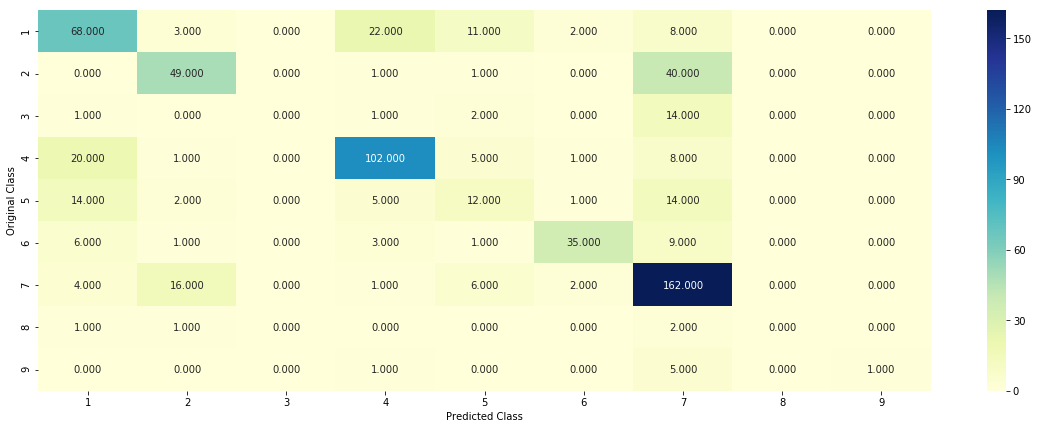

-------------------- Precision matrix (Columm Sum=1) --------------------


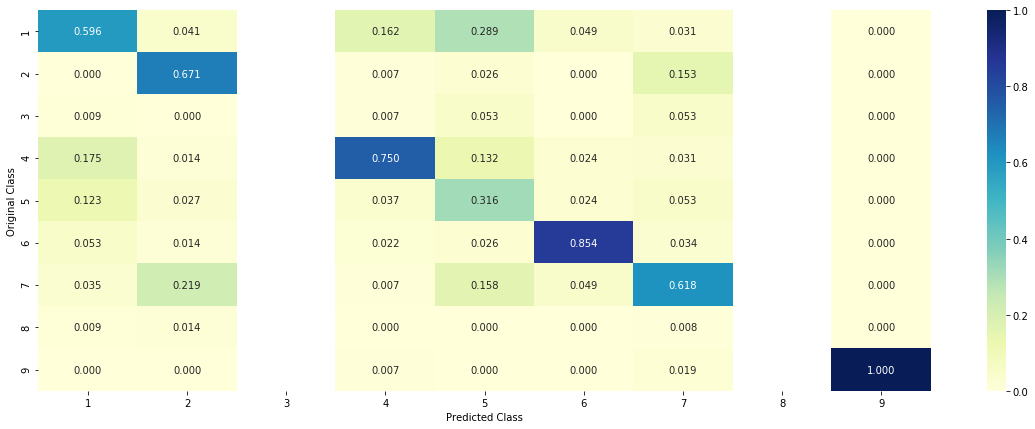

-------------------- Recall matrix (Row sum=1) --------------------


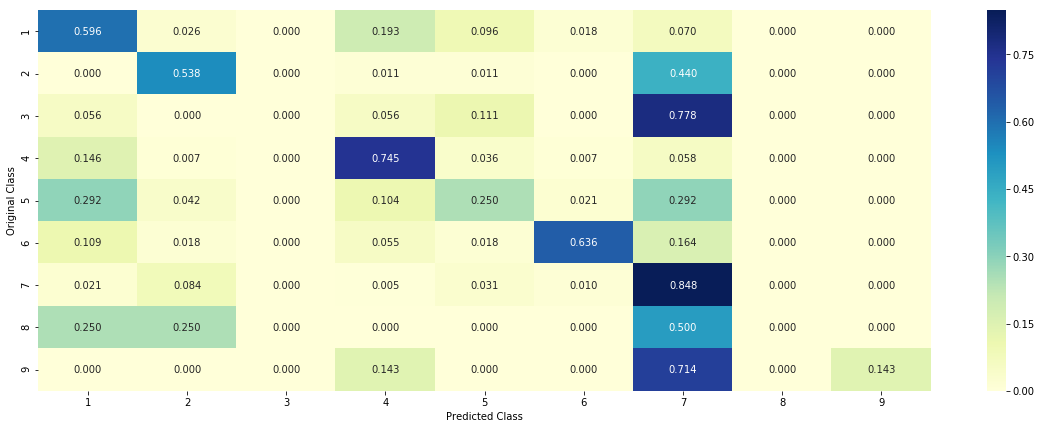

In [93]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_vec, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_vec))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_vec))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_vec))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_vec)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_vec))

### Maximum Voting classifier 

Log loss (train) on the VotingClassifier : 0.8565659723221687
Log loss (CV) on the VotingClassifier : 1.1576533848750443
Log loss (test) on the VotingClassifier : 1.1643755127972553
Number of missclassified point : 0.35789473684210527
-------------------- Confusion matrix --------------------


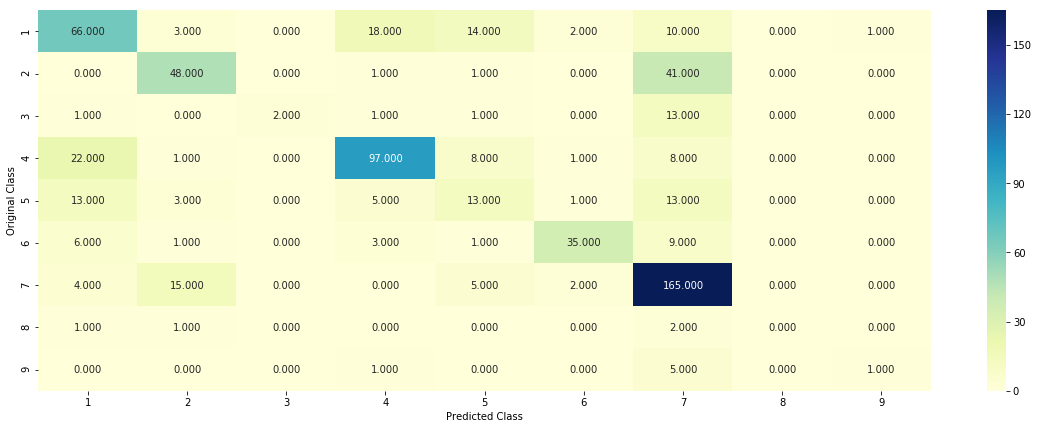

-------------------- Precision matrix (Columm Sum=1) --------------------


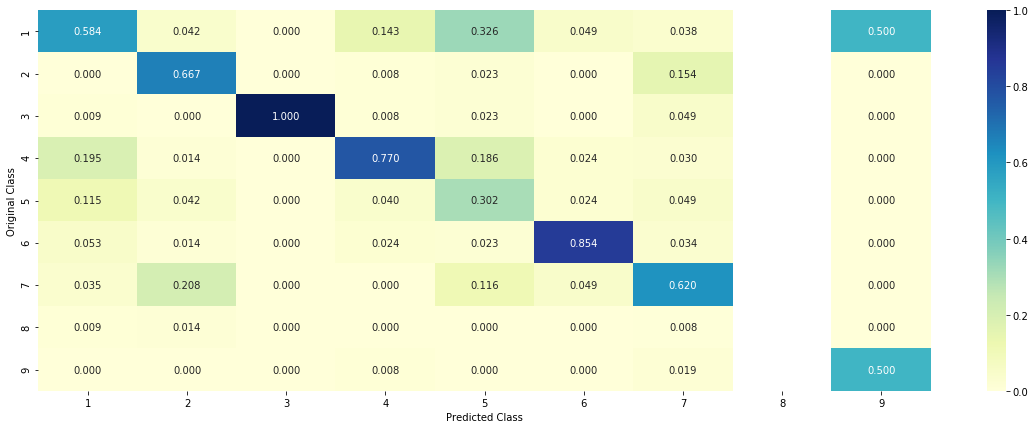

-------------------- Recall matrix (Row sum=1) --------------------


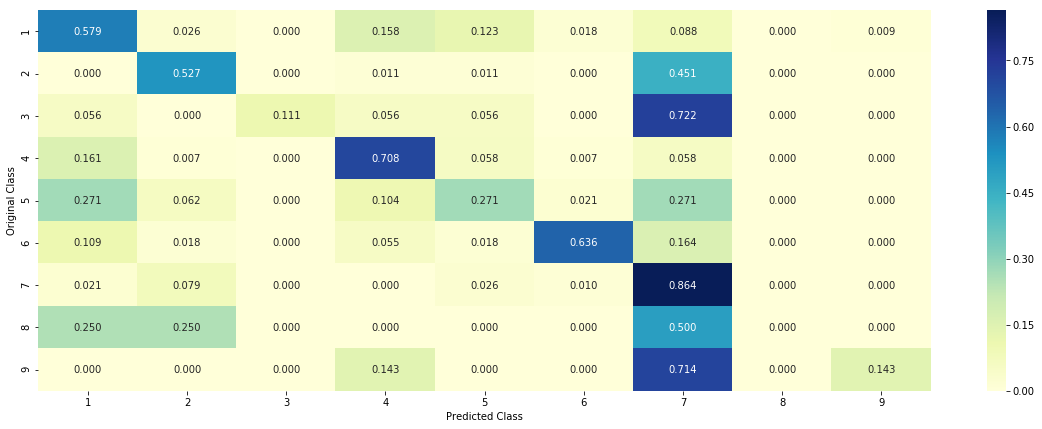

In [94]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_vec, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_vec)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_vec)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_vec)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_vec)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_vec))

## Instead of using all the words in the dataset, use only the top 1000 words based of tf-idf values

In [15]:
text_vectorizer.idf_.shape

(126099,)

In [16]:
train_text_feature.shape

(2124, 126099)

In [17]:
df=pd.DataFrame(text_vectorizer.get_feature_names())

In [18]:
mean_tf=np.mean(train_text_feature,axis=0)
mean_tf


matrix([[0.00410664, 0.00943086, 0.00065508, ..., 0.00047081, 0.00047081,
         0.00047081]])

In [19]:
x=np.array(mean_tf)[0].tolist()

In [20]:
important_feat=[]
important_feat=np.argsort((x))[::-1]
important_feat=important_feat[:1000]
important_feat.shape

(1000,)

In [21]:
np.argmax(mean_tf)

19795

In [22]:
np.max(mean_tf)

0.019041245324341777

In [23]:
imp_feat=[]
for index in important_feat:
    imp_feat.append(df.iloc[index])

In [24]:
x=np.array(imp_feat)
feature=[]
for i in x:
    for j in i:
        feature.append(j)

In [25]:
text_vectorizer=TfidfVectorizer()
text_vectorizer.fit(feature)
train=text_vectorizer.transform(train_df['TEXT'])
test=text_vectorizer.transform(test_df['TEXT'])
cv=text_vectorizer.transform(cv_df['TEXT'])

In [26]:
train_vec = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train))
test_vec = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test))
cv_vec = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv))

### Logistic Regression with class Balance

for alpha = 1e-06
Log Loss : 1.1011976653190054
for alpha = 1e-05
Log Loss : 1.0525242861483708
for alpha = 0.0001
Log Loss : 0.9932250639803677
for alpha = 0.001
Log Loss : 1.0253601459328905
for alpha = 0.01
Log Loss : 1.1704809031082442
for alpha = 0.1
Log Loss : 1.4806280813212045
for alpha = 1
Log Loss : 1.6569474163813263
for alpha = 10
Log Loss : 1.6786255997965651
for alpha = 100
Log Loss : 1.680908657292085


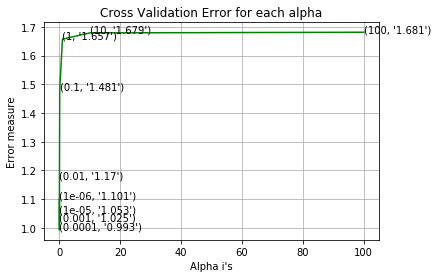

For values of best alpha =  0.0001 The train log loss is: 0.4627039169136912
For values of best alpha =  0.0001 The cross validation log loss is: 0.9932250639803677
For values of best alpha =  0.0001 The test log loss is: 1.0185008365416044


In [132]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

predict_y = sig_clf.predict_proba(train_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### Testing the model with best hyper paramters

Log loss : 0.9932250639803677
Number of mis-classified points : 0.32706766917293234
-------------------- Confusion matrix --------------------


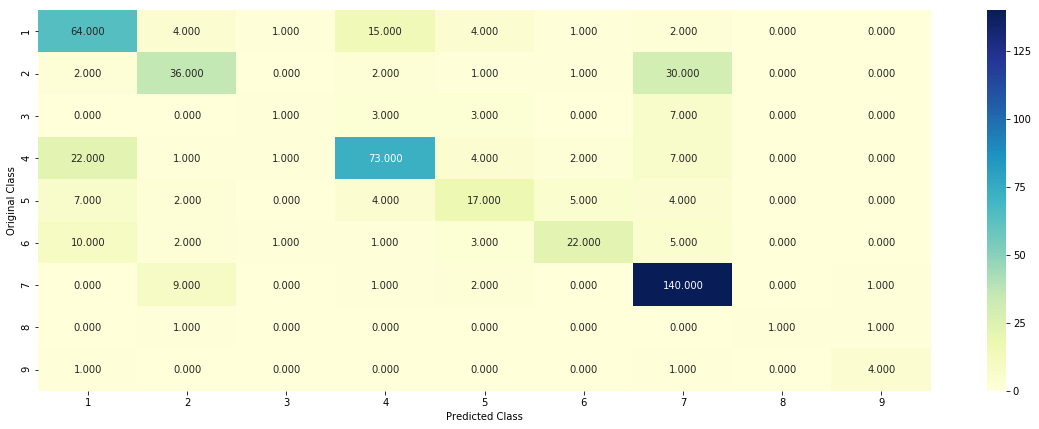

-------------------- Precision matrix (Columm Sum=1) --------------------


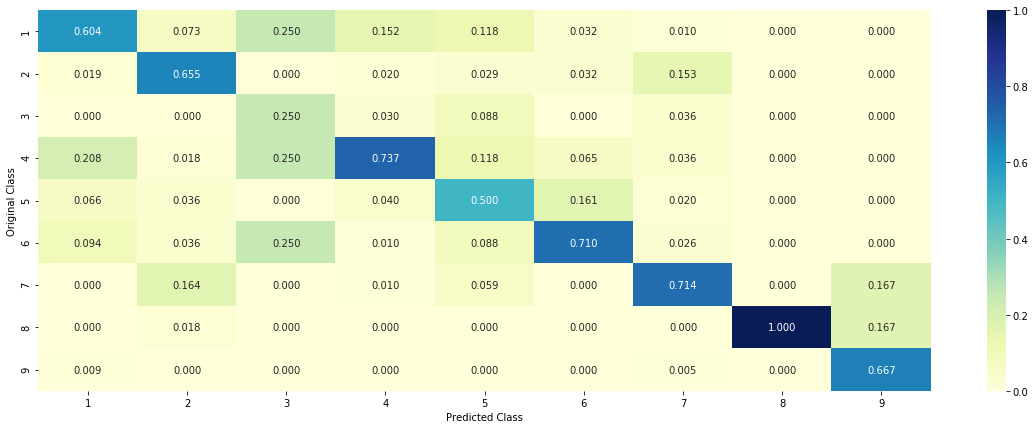

-------------------- Recall matrix (Row sum=1) --------------------


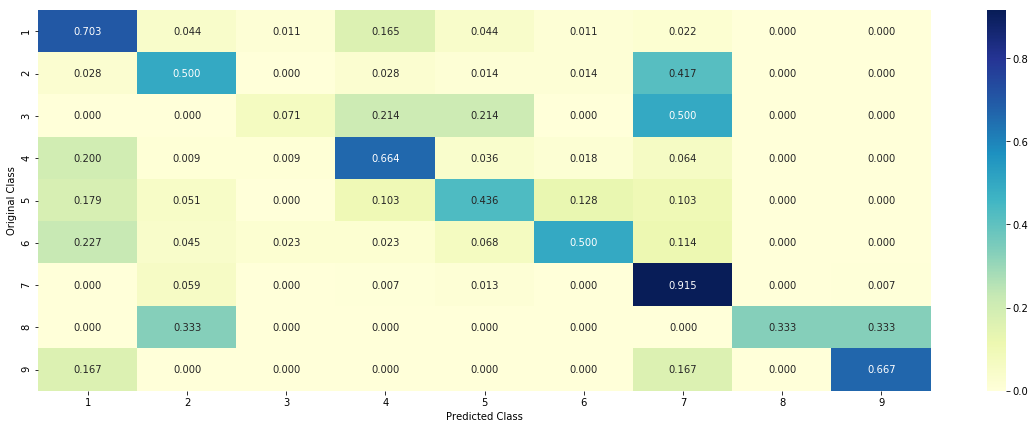

In [133]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_vec, train_y, cv_vec, cv_y, clf)


In [113]:
text_vectorizer

(2124, 1000)

In [137]:
test_vec=test_vec.tocsr()

In [27]:
#Feature importance for tfidf with 1000 features
def get_impfeature_names_tf_imp(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vectorizer.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### Feature Importance, Correctly classified point

In [139]:



# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf_imp(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0204 0.1397 0.0162 0.0211 0.0532 0.0178 0.7217 0.0065 0.0034]]
Actual Class : 7
--------------------------------------------------
0 Text feature [activation] present in test data point [True]
17 Text feature [mutant] present in test data point [True]
18 Text feature [oncogenic] present in test data point [True]
20 Text feature [high] present in test data point [True]
21 Text feature [cells] present in test data point [True]
22 Text feature [tyrosine] present in test data point [True]
26 Text feature [cancers] present in test data point [True]
28 Text feature [signaling] present in test data point [True]
58 Text feature [fig] present in test data point [True]
65 Text feature [12] present in test data point [True]
71 Text feature [increased] present in test data point [True]
78 Text feature [fold] present in test data point [True]
90 Text feature [proliferation] present in test data point [True]
93 Text feature [per] present in test

#### Feature Importance, Incorrectly classified point

In [142]:
test_point_index = 300
no_feature = 500
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_tf_imp(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0321 0.1555 0.0147 0.0322 0.0776 0.0115 0.6683 0.005  0.0031]]
Actual Class : 2
--------------------------------------------------
0 Text feature [activation] present in test data point [True]
12 Text feature [somatic] present in test data point [True]
13 Text feature [downstream] present in test data point [True]
17 Text feature [mutant] present in test data point [True]
20 Text feature [high] present in test data point [True]
21 Text feature [cells] present in test data point [True]
22 Text feature [tyrosine] present in test data point [True]
28 Text feature [signaling] present in test data point [True]
58 Text feature [fig] present in test data point [True]
65 Text feature [12] present in test data point [True]
71 Text feature [increased] present in test data point [True]
78 Text feature [fold] present in test data point [True]
90 Text feature [proliferation] present in test data point [True]
98 Text feature [also] present in te

In [28]:
test_vec=test_vec.tocsr()

# Apply Logistic regression with CountVectorizer Features, including both unigrams and bigrams

In [143]:
text_vectorizer = CountVectorizer(min_df=3,ngram_range=(1,2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 796397


In [144]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [145]:
train_vec = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train_text_feature_onehotCoding))
test_vec = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test_text_feature_onehotCoding))
cv_vec = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv_text_feature_onehotCoding))

### Logistic regression

In [12]:
#feature importance for 2gram BoW
def get_impfeature_names_bow_2gram(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3,ngram_range=(1,2))
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

for alpha = 1e-06
Log Loss : 1.5452224097324696
for alpha = 1e-05
Log Loss : 1.559690091434177
for alpha = 0.0001
Log Loss : 1.5438538989527038
for alpha = 0.001
Log Loss : 1.4707385242692435
for alpha = 0.01
Log Loss : 1.1566704885794588
for alpha = 0.1
Log Loss : 1.1744047319616486
for alpha = 1
Log Loss : 1.2573623352622487
for alpha = 10
Log Loss : 1.3337836693304905
for alpha = 100
Log Loss : 1.3498408414671528


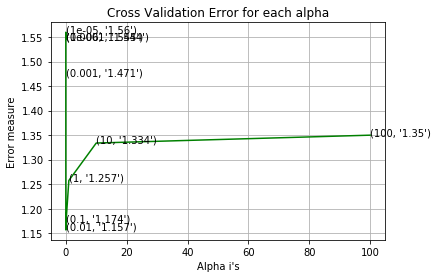

For values of best alpha =  0.01 The train log loss is: 0.8472646352615477
For values of best alpha =  0.01 The cross validation log loss is: 1.1566704885794588
For values of best alpha =  0.01 The test log loss is: 1.176842431113536


In [146]:


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_vec, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_vec, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_vec)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_vec, train_y)

predict_y = sig_clf.predict_proba(train_vec)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_vec)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_vec)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



#### Testing the model with best hyper paramters

Log loss : 1.1566704885794588
Number of mis-classified points : 0.39097744360902253
-------------------- Confusion matrix --------------------


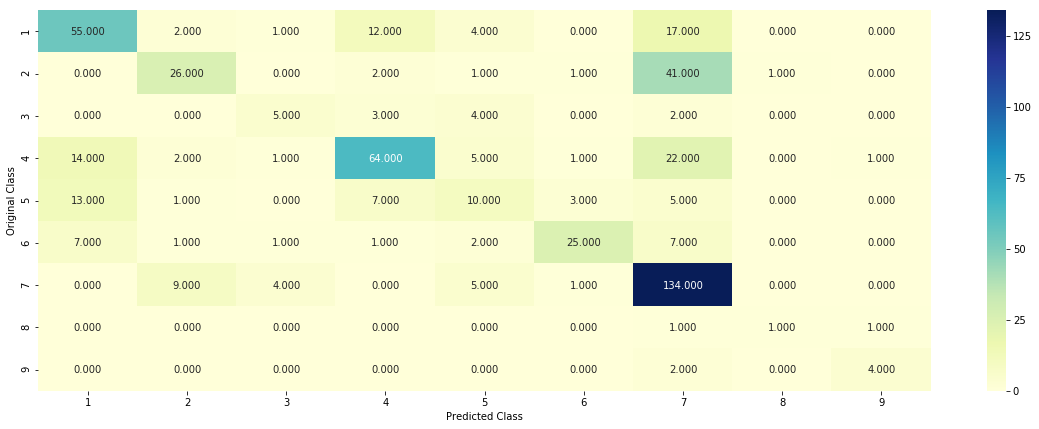

-------------------- Precision matrix (Columm Sum=1) --------------------


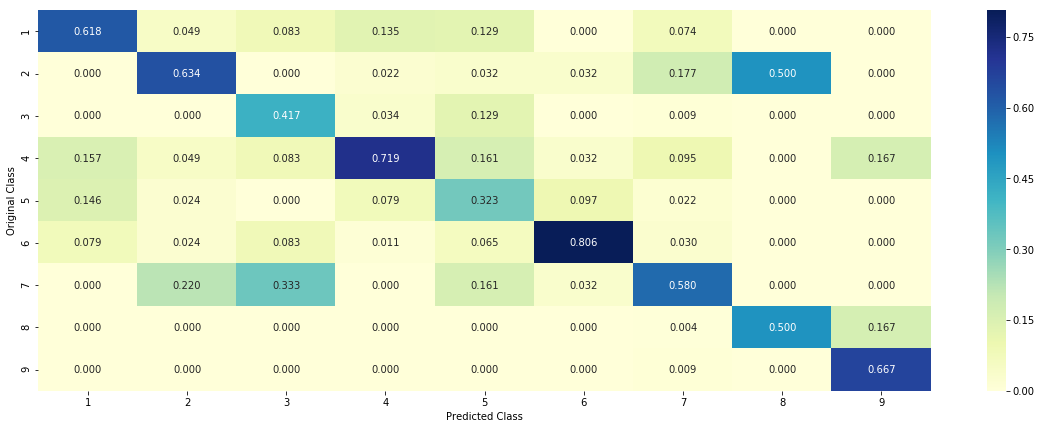

-------------------- Recall matrix (Row sum=1) --------------------


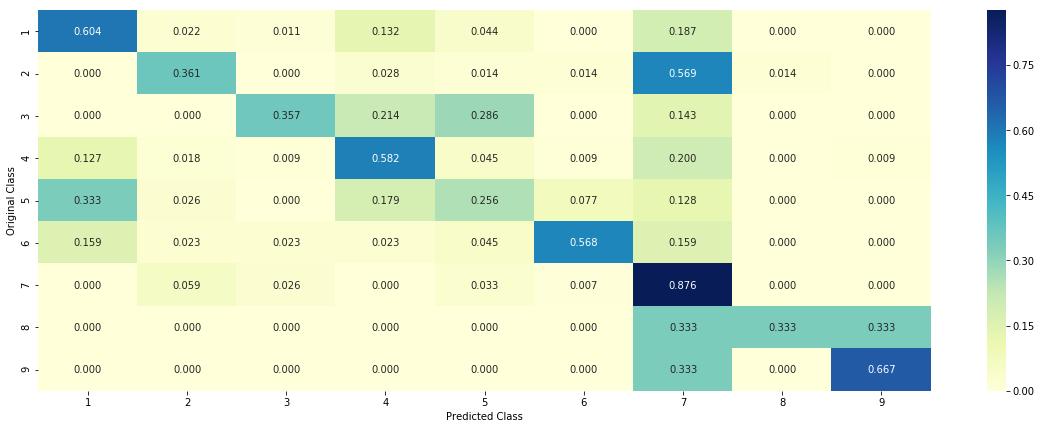

In [147]:

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_vec, train_y, cv_vec, cv_y, clf)




In [227]:
text_count_vec = CountVectorizer(min_df=3,ngram_range=(1,2))
text_vec = text_count_vec.fit(train_df['TEXT'])


#### feature Importance, Correctly classified point

In [150]:
test_vec=test_vec.tocsr()

In [156]:

# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_vec,train_y)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_bow_2gram(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0698 0.0799 0.015  0.0559 0.0225 0.0274 0.7194 0.0048 0.0053]]
Actual Class : 7
--------------------------------------------------
882 Text feature [constitutively] present in test data point [True]
Out of the top  1000  features  1 are present in query point


#### Feature Importance, Incorrectly classified point

In [157]:

test_point_index = 100
no_feature = 1000
predicted_cls = sig_clf.predict(test_vec[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_vec[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names_bow_2gram(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1959 0.1817 0.0238 0.1397 0.0762 0.0701 0.2992 0.006  0.0074]]
Actual Class : 6
--------------------------------------------------
Out of the top  1000  features  0 are present in query point


## Feature Engineering


In [158]:
train_df.head()

,ID,Gene,Variation,Class,TEXT
2426,2426,BRCA1,C64G,4,published analyses effects missense mutations ...
636,636,CDKN1A,Truncating Mutations,1,introduction loss control mammalian cell cycle...
703,703,ERBB2,E812K,6,purpose mutations associated resistance kinase...
1455,1455,FGFR2,K659N,7,activating mutations tyrosine kinase domain re...
103,103,MSH6,R976H,1,msh6 gene one mismatch repair genes involved h...


### Text word length, character length and variation length as features

In [10]:
train_df['word_len']=train_df['TEXT'].apply(lambda x : len(x.split()))
train_df['char_len']=train_df['TEXT'].apply(lambda x : len(x))
test_df['word_len']=test_df['TEXT'].apply(lambda x : len(x.split()))
test_df['char_len']=test_df['TEXT'].apply(lambda x : len(x))
cv_df['word_len']=cv_df['TEXT'].apply(lambda x : len(x.split()))
cv_df['char_len']=cv_df['TEXT'].apply(lambda x : len(x))
train_df.head()

,ID,Gene,Variation,Class,TEXT,word_len,char_len
2426,2426,BRCA1,C64G,4,published analyses effects missense mutations ...,17926,130265
636,636,CDKN1A,Truncating Mutations,1,introduction loss control mammalian cell cycle...,7234,53047
703,703,ERBB2,E812K,6,purpose mutations associated resistance kinase...,4961,37512
1455,1455,FGFR2,K659N,7,activating mutations tyrosine kinase domain re...,8077,59908
103,103,MSH6,R976H,1,msh6 gene one mismatch repair genes involved h...,13352,100388


In [14]:

word_len_train=np.reshape(np.array(train_df['word_len']),(train_df['word_len'].shape[0],1))
char_len_train=np.reshape(np.array(train_df['char_len']),(train_df['char_len'].shape[0],1))
word_len_test=np.reshape(np.array(test_df['word_len']),(test_df['word_len'].shape[0],1))
char_len_test=np.reshape(np.array(test_df['char_len']),(test_df['char_len'].shape[0],1))
word_len_cv=np.reshape(np.array(cv_df['word_len']),(cv_df['word_len'].shape[0],1))
char_len_cv=np.reshape(np.array(cv_df['char_len']),(cv_df['char_len'].shape[0],1))

In [170]:

train_df['Variation_len']=train_df['Variation'].apply(lambda x: len(x))
test_df['Variation_len']=test_df['Variation'].apply(lambda x: len(x))
cv_df['Variation_len']=cv_df['Variation'].apply(lambda x: len(x))


In [171]:
train_df.head()

,ID,Gene,Variation,Class,TEXT,word_len,char_len,Variation_len
2426,2426,BRCA1,C64G,4,published analyses effects missense mutations ...,17926,130265,4
636,636,CDKN1A,Truncating Mutations,1,introduction loss control mammalian cell cycle...,7234,53047,20
703,703,ERBB2,E812K,6,purpose mutations associated resistance kinase...,4961,37512,5
1455,1455,FGFR2,K659N,7,activating mutations tyrosine kinase domain re...,8077,59908,5
103,103,MSH6,R976H,1,msh6 gene one mismatch repair genes involved h...,13352,100388,5


<Figure size 1440x1080 with 0 Axes>

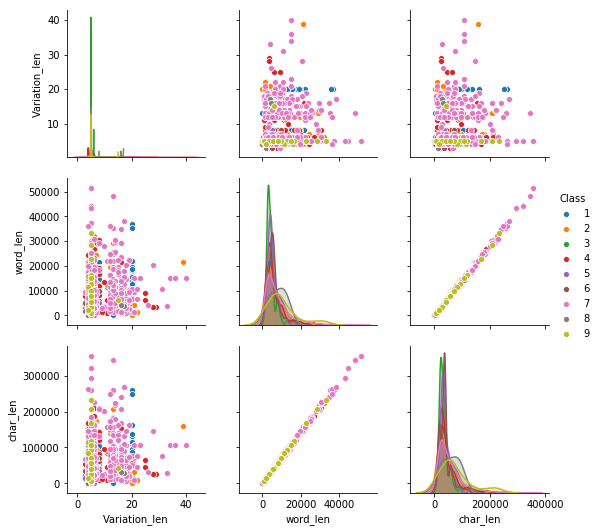

In [244]:
fig = plt.figure(figsize=(20,15))
sns.pairplot(train_df,hue='Class',vars=["Variation_len",'word_len','char_len'])
plt.show()

we can see that the features are not helping in classification and also adding these features did not improve the models.

### Truncated svd to reduce the dimensions

In [207]:

from sklearn.feature_extraction.text import TfidfVectorizer
text_vectorizer = TfidfVectorizer(max_features=10000)
train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
test_text_feature = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])

In [208]:
train_text_feature = normalize(train_text_feature, axis=0)

# don't forget to normalize every feature
test_text_feature = normalize(test_text_feature, axis=0)

cv_text_feature = normalize(cv_text_feature, axis=0)


In [211]:
#stacking the features
train_vec = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train_text_feature))
test_vec = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test_text_feature))
cv_vec = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv_text_feature))

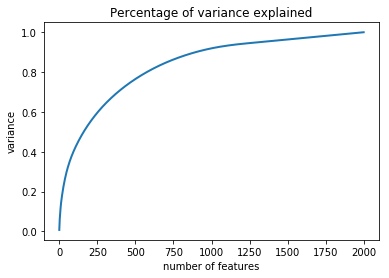

In [213]:
#using tsvd to reduce the dimensions
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
#applying truncated svd with n_components =1000
tsvd =TruncatedSVD(algorithm="randomized",n_components=2000, n_iter=7,\
                   random_state=42,tol=0.0)
X_reduced = tsvd.fit_transform(train_vec)

#plotting the percentage of the variance explained by the features
percentage_variance_explained=tsvd.explained_variance_/sum(tsvd.explained_variance_)
cum_variance_explained=np.cumsum(percentage_variance_explained)
plt.plot(cum_variance_explained,linewidth='2')
plt.xlabel("number of features")
plt.ylabel("variance")
plt.title("Percentage of variance explained")
plt.show()

In [220]:
tsvd =TruncatedSVD(algorithm="randomized",n_components=1500, n_iter=7,\
                   random_state=42,tol=0.0)
tra = tsvd.fit_transform(train_vec)
tes=tsvd.transform(test_vec)
c=tsvd.transform(cv_vec)

## Logistic Regression with Balancing

for alpha = 1e-06
Log Loss : 1.0570658874759329
for alpha = 1e-05
Log Loss : 1.0465970705661962
for alpha = 0.0001
Log Loss : 0.9864306000414919
for alpha = 0.001
Log Loss : 0.9266671112993817
for alpha = 0.01
Log Loss : 1.0057874102939246
for alpha = 0.1
Log Loss : 1.0717122327927189
for alpha = 1
Log Loss : 1.267646051437711
for alpha = 10
Log Loss : 1.6622461851007915
for alpha = 100
Log Loss : 1.7372144829297962


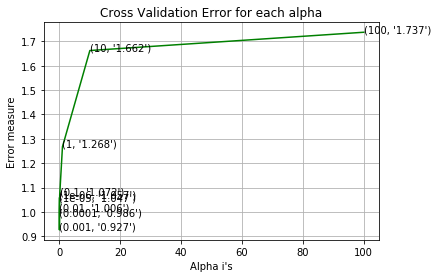

For values of best alpha =  0.001 The train log loss is: 0.5726296501912288
For values of best alpha =  0.001 The cross validation log loss is: 0.9266671112993817
For values of best alpha =  0.001 The test log loss is: 0.9706599524824131


In [221]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tra, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tra, train_y)
    sig_clf_probs = sig_clf.predict_proba(c)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tra, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tra, train_y)

predict_y = sig_clf.predict_proba(tra)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(c)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tes)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.9266671112993817
Number of mis-classified points : 0.31954887218045114
-------------------- Confusion matrix --------------------


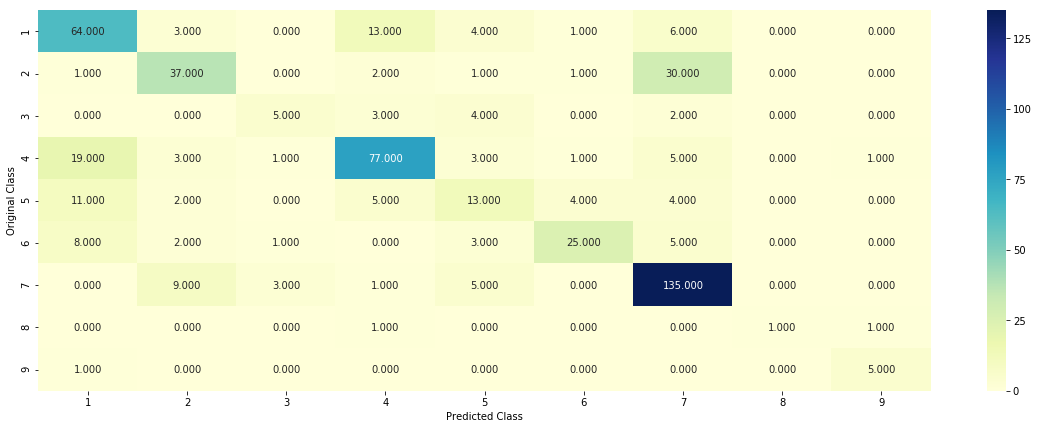

-------------------- Precision matrix (Columm Sum=1) --------------------


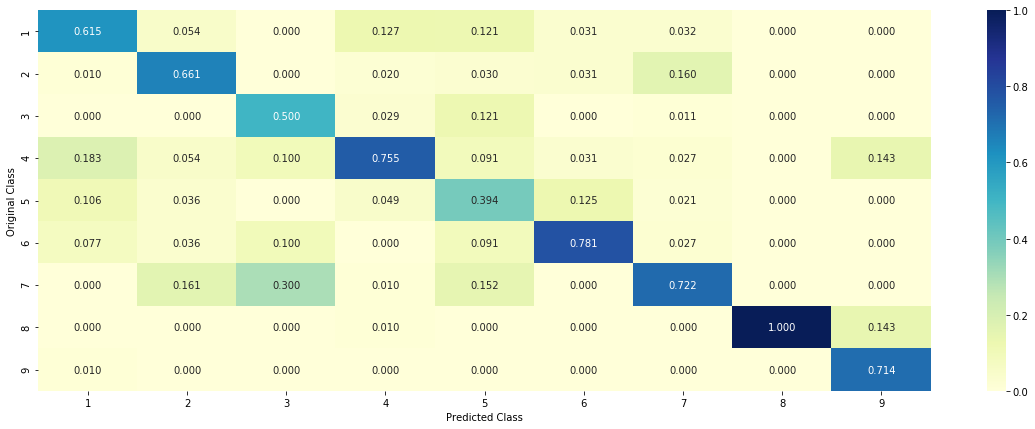

-------------------- Recall matrix (Row sum=1) --------------------


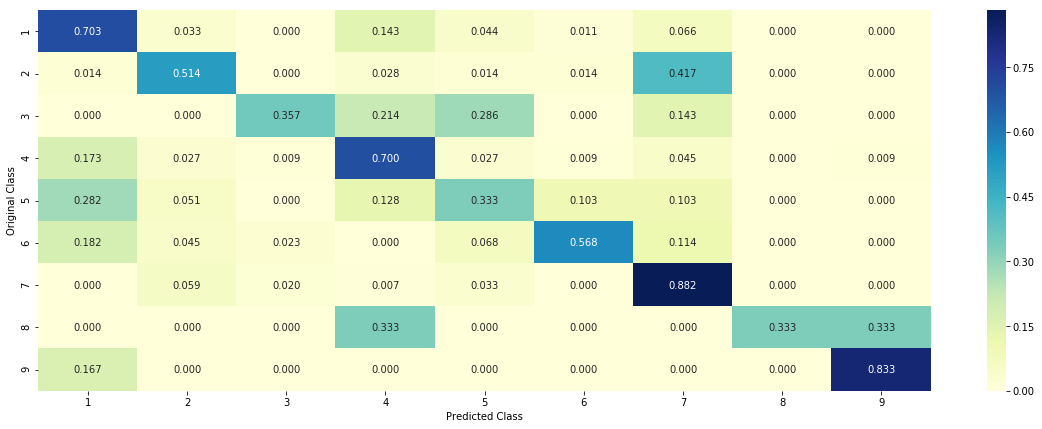

In [222]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(tra, train_y, c, cv_y, clf)

### Logistic Regression without Class Balance

for alpha = 1e-06
Log Loss : 1.0376463311304114
for alpha = 1e-05
Log Loss : 1.0288008319989888
for alpha = 0.0001
Log Loss : 0.9930706350433093
for alpha = 0.001
Log Loss : 0.9241393237294904
for alpha = 0.01
Log Loss : 0.9950353774753347
for alpha = 0.1
Log Loss : 1.0832774813439614
for alpha = 1
Log Loss : 1.241828571935979
for alpha = 10
Log Loss : 1.6463772476034435
for alpha = 100
Log Loss : 1.7628574422286374


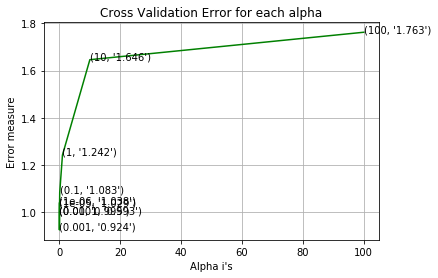

For values of best alpha =  0.001 The train log loss is: 0.5605561048509772
For values of best alpha =  0.001 The cross validation log loss is: 0.9241393237294904
For values of best alpha =  0.001 The test log loss is: 0.9642156482902127


In [239]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier( alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tra, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tra, train_y)
    sig_clf_probs = sig_clf.predict_proba(c)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tra, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tra, train_y)

predict_y = sig_clf.predict_proba(tra)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(c)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tes)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.9241393237294904
Number of mis-classified points : 0.3233082706766917
-------------------- Confusion matrix --------------------


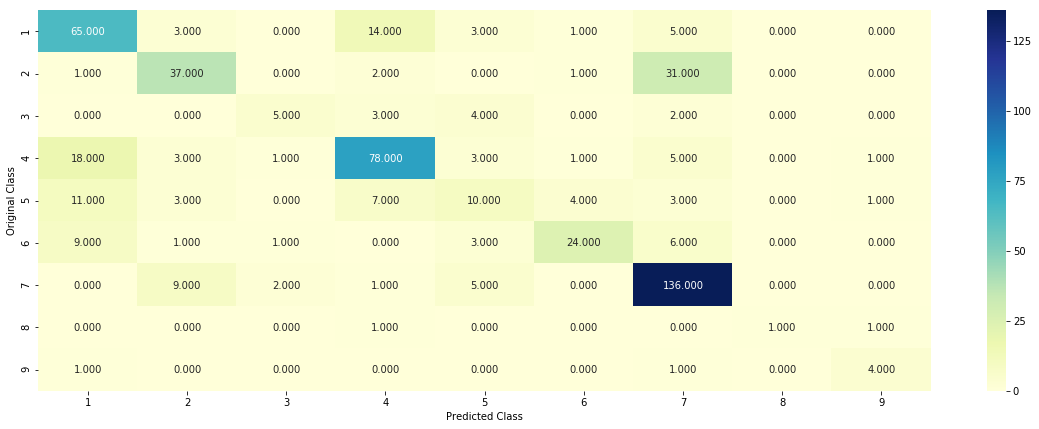

-------------------- Precision matrix (Columm Sum=1) --------------------


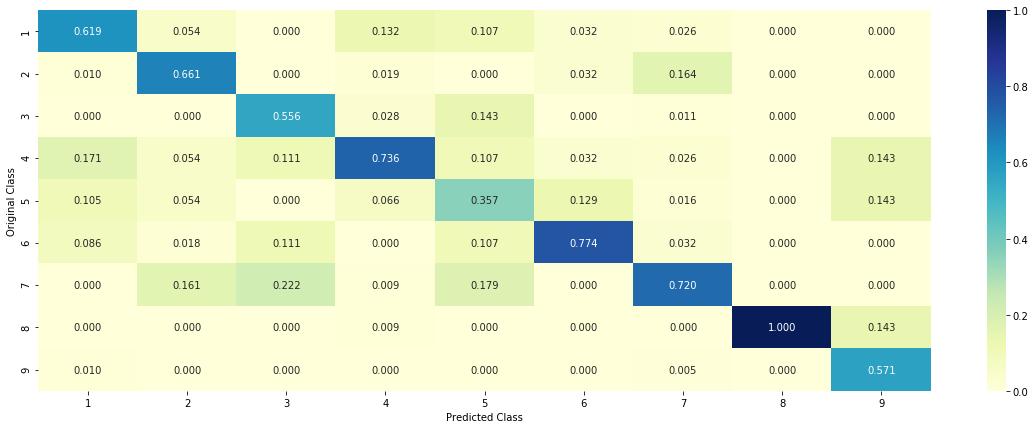

-------------------- Recall matrix (Row sum=1) --------------------


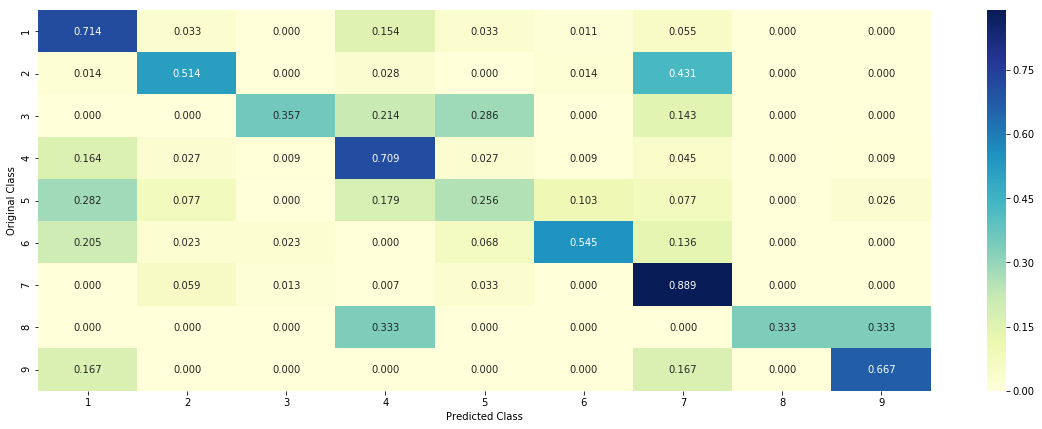

In [240]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(tra, train_y, c, cv_y, clf)

## Conclusion

Objective:Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

1. We are given a dataset with 3321 rows and 5 columns: ID , Gene, Variations, Text, Class of which Class is a multiclass column containing the 9 classes. 
<br>
2. We preprocess the data and split into train, test and cv set. 
<br>
3. We perform EDA on the dataset to know about the distribution of the data and get more insights about the data and featurize the data using responsecoding and onehotencoding method.
<br>
4. We then check if distribution is stable across train test and cv set and then check how important gene and variation feature is in classifying the model.
<br>
5. We then apply various model like logistic Regression, Naive Bayes, Random Forest, Voting classifier etc and compare them.
<br>
6. We use multiclass log loss as error metric, confusion matrix as performance metric and also check the number of misclassified points.
<br>
7. Since interpretibility is important we used only models which are interpretable and got the feature importance.
<br>
8. We then try to reduce the log loss using other techniques like tfidf vectorization, BoW Vectorization with 2 gram and tsvd.


In [241]:
from prettytable import PrettyTable

x=PrettyTable()

x.field_names=['Algorithm','Vectorizer','penalty','alpha','CV Log loss','Test Log Loss',"Misclassified Points(%)"]
x.add_row(["Naive Bayes","TFIDF",'-',1,1.188, 1.176,39.47])
x.add_row(["KNN","TFIDF",'-',5,1.329 ,1.326,  42.66 ])
x.add_row(["Logistic Regression (Balanced) ","TFIDF",'l2',0.001,1.097, 1.064, 34.96 ])
x.add_row(["Logistic Regression","TFIDF",'l2',0.001,1.113, 1.072 ,34.39 ])
x.add_row(["Random Forest","TFIDF",'-',2000,1.172, 1.16, 37.78 ])
x.add_row(["Stacking","TFIDF",'-','-',1.129 ,1.109, 35.48 ])
x.add_row(["Logistic Regression (Balanced)","TFIDF-1000",'l2',0.0001,0.9932, 1.018 ,32.706 ])
x.add_row(["Logistic Regression (Balanced)","BoW 2 gram",'l2',0.01,1.156 ,1.176, 39.09 ])
x.add_row(["Logistic Regression (Balanced)","TFIDF-TSVD",'l2',0.001,0.9266, 0.9706, 31.95])
x.add_row(["Logistic Regression","TFIDF-TSVD",'l2',0.001,0.924, 0.964, 32.33])


print(x)

+---------------------------------+------------+---------+--------+-------------+---------------+-------------------------+
|            Algorithm            | Vectorizer | penalty | alpha  | CV Log loss | Test Log Loss | Misclassified Points(%) |
+---------------------------------+------------+---------+--------+-------------+---------------+-------------------------+
|           Naive Bayes           |   TFIDF    |    -    |   1    |    1.188    |     1.176     |          39.47          |
|               KNN               |   TFIDF    |    -    |   5    |    1.329    |     1.326     |          42.66          |
| Logistic Regression (Balanced)  |   TFIDF    |    l2   | 0.001  |    1.097    |     1.064     |          34.96          |
|       Logistic Regression       |   TFIDF    |    l2   | 0.001  |    1.113    |     1.072     |          34.39          |
|          Random Forest          |   TFIDF    |    -    |  2000  |    1.172    |      1.16     |          37.78          |
|       

Logistic Regression with TFIDf using tsvd reduced features has the log loss of 0.97 and lowest percent of misclassified points .